In [70]:
import pandas as pd
import numpy as np
import sqlalchemy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


from data import db
from ml.processing import var_to_str
from ml.labels import apply_triple_barrier
from ml.analytics import exponential_decay, return_attribution

from ml_model.pipeline import get_pipeline, save_pipeline

%load_ext autoreload
%autoreload 2



SYMBOL = "BTC"
start = "2023-06"
end = "2024"

DB = db.connect_db("database", interval="1h")
data = DB.get_data(SYMBOL)
data = data.loc[start:end]


def var_to_str(data):
    data.columns = [str(col) if isinstance(col, sqlalchemy.sql.elements.quoted_name) else col for col in data.columns]


#data.reset_index(inplace=True)
var_to_str(data)

data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,open,high,low,close,volume
time,,,,,
2023-06-01 00:00:00,27210.36,27350.00,27023.35,27065.77,2772.82443
2023-06-01 01:00:00,27065.76,27165.47,27059.74,27078.56,1785.47203
2023-06-01 02:00:00,27078.56,27114.16,26640.00,26719.26,3775.37874
2023-06-01 03:00:00,26719.26,26838.89,26605.05,26779.94,2879.51275
2023-06-01 04:00:00,26779.93,26822.81,26746.00,26804.15,1223.77081


### Triple Barrier

In [71]:
# Calcul de la volatilité
def compute_daily_volatility(price_series, span=100):
    returns = price_series.pct_change()
    volatility = returns.ewm(span=span).std()
    return volatility


# Get events
def get_events(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False):
    #trgt = trgt[trgt > minRet]
    trgt = trgt.where(trgt >= min_ret, min_ret)
    if t1 is False: t1 = pd.Series(pd.NaT, index=tEvents)
    out = pd.DataFrame(index=tEvents)
    out['t1'] = t1.loc[out.index]
    out['trgt'] = trgt.loc[out.index]
    if ptSl[0] > 0: out['pt'] = ptSl[0] * out['trgt']
    else: out['pt'] = pd.Series(index=tEvents)
    if ptSl[1] > 0: out['sl'] = -ptSl[1] * out['trgt']
    else: out['sl'] = pd.Series(index=tEvents)
    return out


def apply_pt_sl_on_t1(close, events, ptSl, molecule):
    out = events.loc[molecule].copy(deep=True)
    if ptSl[0] > 0: pt = ptSl[0] * events['trgt']
    else: pt = pd.Series(index=events.index)
    if ptSl[1] > 0: sl = -ptSl[1] * events['trgt']
    else: sl = pd.Series(index=events.index)
    
    for loc, t1 in events['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # chemin des prix
        df0 = (df0 / close[loc] - 1)
        out.at[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # stop-loss
        out.at[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # prise de profit
    return out


def get_bins(events, close):
    events['out'] = np.nan
    first_touch = events[['sl', 'pt', 't1']].dropna(how='all').copy()
    first_touch['pt'] = pd.to_datetime(first_touch['pt'], errors='coerce')
    first_touch['sl'] = pd.to_datetime(first_touch['sl'], errors='coerce')
    first_touch = first_touch.min(axis=1)
    for loc, t in first_touch.items():
        if pd.isnull(t): continue
        if t == events.loc[loc, 't1']: events.at[loc, 'out'] = 0
        elif t == events.loc[loc, 'pt']: events.at[loc, 'out'] = 1
        elif t == events.loc[loc, 'sl']: events.at[loc, 'out'] = -1
    events['ret'] = np.log(close.shift(1) / close)
    return events


# Calcul de la volatilité
data['volatility'] = compute_daily_volatility(data['close'])
"""
# Définir les événements - par exemple, chaque jour à 00:00
events = pd.DataFrame(index=data.index)
#events = pd.DataFrame(index=data.resample('1D').first().dropna().index)
events['t1'] = events.index + pd.Timedelta(days=1)  # Barrière verticale après 1 jour
events['trgt'] = data['volatility'].resample('1D').last() * 2  # Objectif basé sur la volatilité
events['side'] = 1  # Par exemple, prendre des positions longues
"""
# Définir les événements - par exemple, chaque jour à 00:00
events = pd.DataFrame(index=data.index)
events['t1'] = pd.to_datetime(events.index.strftime('%Y-%m-%d')) +  pd.Timedelta(days=1)
events['trgt'] = data['volatility'] * 2 
events['side'] = 1 

# Appliquer la méthode des trois barrières
ptSl = [1, 1]
min_ret = 0.01
num_threads = 1

events = get_events(data['close'], events.index, ptSl, events['trgt'], min_ret, num_threads, t1=events['t1'])


molecule = events.index  # Liste des indices des événements
events2 = apply_pt_sl_on_t1(data['close'], events, ptSl, molecule)

events2

C:\Users\Dell\AppData\Local\Temp\ipykernel_28384\1696750956.py:33: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-06-01 02:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\Dell\AppData\Local\Temp\ipykernel_28384\1696750956.py:34: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



,t1,trgt,pt,sl
time,,,,
2023-06-01 00:00:00,2023-06-02,0.010000,NaN,2023-06-01 02:00:00
2023-06-01 01:00:00,2023-06-02,0.010000,NaN,2023-06-01 02:00:00
2023-06-01 02:00:00,2023-06-02,0.019433,NaN,NaT
2023-06-01 03:00:00,2023-06-02,0.017022,NaN,NaT
2023-06-01 04:00:00,2023-06-02,0.014525,NaN,NaT
...,...,...,...,...
2023-12-31 19:00:00,2024-01-01,0.010000,NaN,NaN
2023-12-31 20:00:00,2024-01-01,0.010000,NaN,NaN
2023-12-31 21:00:00,2024-01-01,0.010000,NaN,NaN


In [72]:

labels = get_bins(events2, close=data['close'])


labels['out'] = np.where(labels['out'] == 0, 
                        np.where(labels['ret'] > 0, 1, -1),
                        labels['out']
                        )

labels['out'].value_counts()

out
 1.0    2646
-1.0    2490
Name: count, dtype: int64

In [73]:

from ml_model.evaluation import evaluate_model
from ml_model.model import train_model


data['Y'] = labels['out']

X = data.drop(columns=['Y'])
y = data['Y']

# Séparation en ensembles d'entraînement et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


test_size = int(len(data) * 0.2)

# Division des données
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]


pipeline = get_pipeline()
save_pipeline(pipeline)

X_train_x = pipeline.fit_transform(X_train)
X_test_x = pipeline.fit_transform(X_test)

y_train_x = y_train.loc[X_train_x.index]
y_test_x = y_test.loc[X_test_x.index]

model = train_model(X_train_x, y_train_x)

c:\Users\Dell\Desktop\CedAlgo\StrategyLab\ml_model\pipeline.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Dell\Desktop\CedAlgo\StrategyLab\ml_model\pipeline.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\Dell\Desktop\CedAlgo\StrategyLab\ml_model\pipeline.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [74]:
model

RandomForestClassifier()

In [86]:
y_pred_proba = model.predict_proba(X_test_x)

y_pred = model.predict(X_test_x)
y_true = y_test_x

accuracy, report, confusion = evaluate_model(y_true, y_pred)

In [94]:
y_pred_proba

array([[0.44, 0.56],
       [0.35, 0.65],
       [0.4 , 0.6 ],
       ...,
       [0.48, 0.52],
       [0.35, 0.65],
       [0.68, 0.32]])

## Evaluation

In [107]:
print("Accuracy : ",accuracy)
print("Report : ",report)

Accuracy :  0.6825396825396826
Report :                precision    recall  f1-score   support

        -1.0       0.70      0.57      0.63       477
         1.0       0.67      0.78      0.72       531

    accuracy                           0.68      1008
   macro avg       0.69      0.68      0.68      1008
weighted avg       0.69      0.68      0.68      1008



# Backtest

In [100]:
px.box(backtest['proba'])

In [103]:
import plotly.express as px

backtest = X_test.copy()
backtest['pred'] = y_pred
backtest['proba'] = y_pred_proba[:,0]
backtest['pred'] = np.where(backtest['proba'] > 0.67, 1, np.where(backtest['proba']<0.29, -1, 0))

backtest['cum_ret'] = (1 + backtest['return']).cumprod()
backtest['strategy'] = backtest['return'] * backtest['pred']
backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()


In [104]:
backtest[['return', 'pred', 'strategy', 'strategy_cum_ret']]

,return,pred,strategy,strategy_cum_ret
time,,,,
2023-11-20 00:00:00,-0.001620,0,-0.000000,1.000000
2023-11-20 01:00:00,-0.000212,0,-0.000000,1.000000
2023-11-20 02:00:00,0.000334,0,0.000000,1.000000
2023-11-20 03:00:00,-0.005082,0,-0.000000,1.000000
2023-11-20 04:00:00,0.002504,0,0.000000,1.000000
...,...,...,...,...
2023-12-31 19:00:00,-0.000883,0,-0.000000,4.316224
2023-12-31 20:00:00,-0.001432,0,-0.000000,4.316224
2023-12-31 21:00:00,-0.000876,0,-0.000000,4.316224


<Axes: xlabel='time'>

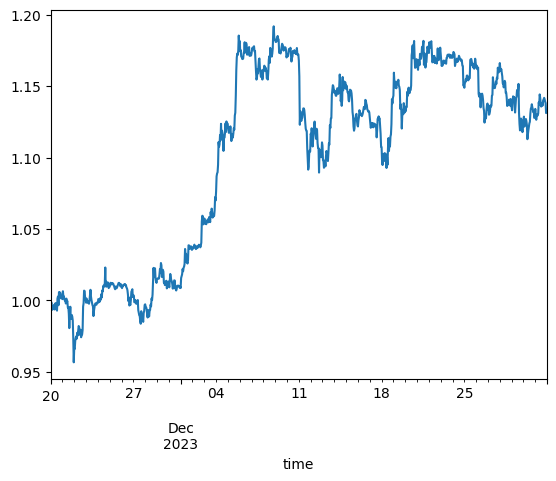

In [105]:
backtest['cum_ret'].plot()

In [106]:
px.line(backtest[['cum_ret', 'strategy_cum_ret']])

Total Return: 57.45526916009833


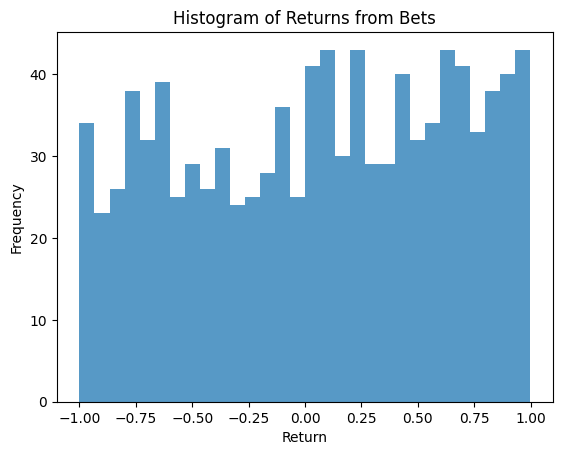

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_bet_sizes(num_bets, true_prob):
    np.random.seed(42)
    outcomes = np.random.rand(num_bets) < true_prob
    bet_sizes = np.random.rand(num_bets)
    returns = bet_sizes * outcomes - bet_sizes * (1 - outcomes)
    return returns

# Paramètres de la simulation
num_bets = 1000
true_prob = 0.55  # Probabilité que le pari soit favorable

# Exécuter la simulation
returns = simulate_bet_sizes(num_bets, true_prob)

# Calculer le rendement total et afficher les résultats
total_return = np.sum(returns)
print(f"Total Return: {total_return}")

# Afficher l'histogramme des retours
plt.hist(returns, bins=30, alpha=0.75)
plt.title('Histogram of Returns from Bets')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()


c:\Users\Dell\miniconda3\envs\RL\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\Dell\miniconda3\envs\RL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Dell\miniconda3\envs\RL\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Dell\miniconda3\envs\RL\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Dell\miniconda3\envs\RL\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


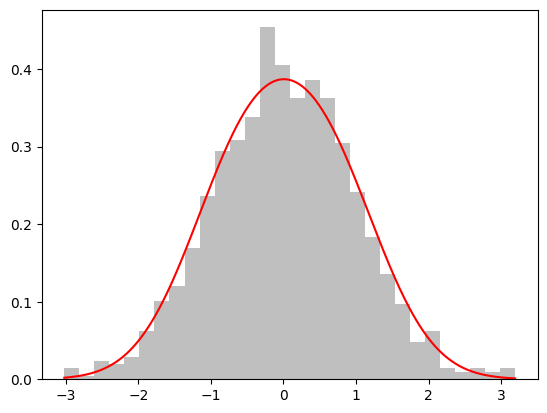

In [82]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Exemple de données
data = np.random.randn(1000)

# Ajustement du mélange de deux Gaussiennes
gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

# Estimation des responsabilités
responsibilities = gmm.predict_proba(data.reshape(-1, 1))

# Calcul de la taille du pari
bet_size = responsibilities[:, 1]  # Utiliser la deuxième composante comme exemple

# Tracer les données et la taille des paris
plt.hist(data, bins=30, density=True, alpha=0.5, color='gray')
x = np.linspace(min(data), max(data), 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
plt.plot(x, pdf, '-r')
plt.show()


In [108]:
import numpy as np
from sklearn.model_selection import KFold

class PurgedKFold(KFold):
    def __init__(self, n_splits=5, embargo=0):
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.embargo = embargo

    def split(self, X, y=None, groups=None):
        indices = np.arange(len(X))
        test_starts = [(i[0], i[-1] + 1) for i in np.array_split(indices, self.n_splits)]
        for start, end in test_starts:
            t_ind = np.arange(start, end)
            train_indices = np.concatenate([np.arange(0, start), np.arange(end, len(X))])
            # Embargo applied here
            if self.embargo > 0:
                train_indices = np.setdiff1d(train_indices, np.arange(end, end + self.embargo))
            yield train_indices, t_ind




In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Création d'un ensemble de données fictif
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Instancier le modèle
model = RandomForestClassifier(random_state=42)

# Instancier le PurgedKFold
n_splits = 5
embargo = 10  # Définir selon la taille de votre ensemble de données
cv = PurgedKFold(n_splits=n_splits, embargo=embargo)

# Effectuer la validation croisée
scores = []
for train_indices, test_indices in cv.split(X):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

print("Scores de validation croisée :", scores)


Scores de validation croisée : [0.925, 0.915, 0.875, 0.88, 0.855]
